In [6]:
import json
import random
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt

from h_json import *
from h_detectron2 import *
from h_maskcut import *

In [7]:
# dataset location
syspath="/home/dkhatanassia/detectron2_dataset"

# pick dataset
dataset = 'jerry_2500GT'

##### required paths ######
root = join(syspath,dataset)
imgs = join(root,'imgs')
imgs_mc = join(root,'imgs_mc')
imgs_tau = join(root,'imgs_tau')
anns = join(root,'annotations')
anns_tmp = join(anns,'sub')

# name of file and path to json{train, test}
json_name_GT = f'GT_{dataset}.json'
json_name_GT_tr = f'tr_GT_{dataset}.json'
json_name_GT_te = f'te_GT_{dataset}.json'
json_name_mc = f'mc_{dataset}.json'
json_name_mc_tr = f'tr_mc_{dataset}.json'
json_name_mc_te = f'te_mc_{dataset}.json'

json_path_GT = join(anns,json_name_GT)
json_path_GT_tr = join(anns,json_name_GT_tr)
json_path_GT_te = join(anns,json_name_GT_te)
json_path_mc = join(anns,json_name_mc)
json_path_mc_tr = join(anns,json_name_mc_tr)
json_path_mc_te = join(anns,json_name_mc_te)

#### prepare img for maskcut

In [8]:
# send all images to subfolders in imgs_mc directory
if False: toTrainSubfolders(imgs,imgs_mc,50, sublist=False)


# send only 100 images to subfolders in imgs_tau directory (used to run MaskCut with different {tau} to assess performances)
rdm100 = [d for d in listdir(imgs)]
random.seed(10)
shuffle(rdm100)
rdm100 = sorted(rdm100[:100])

if False: toTrainSubfolders(imgs,imgs_tau,50, sublist=rdm100)

#### **==> Run Maskcut on imgs_tau (use 11_MaskCut.ipynb)**

#### plot results for several tau

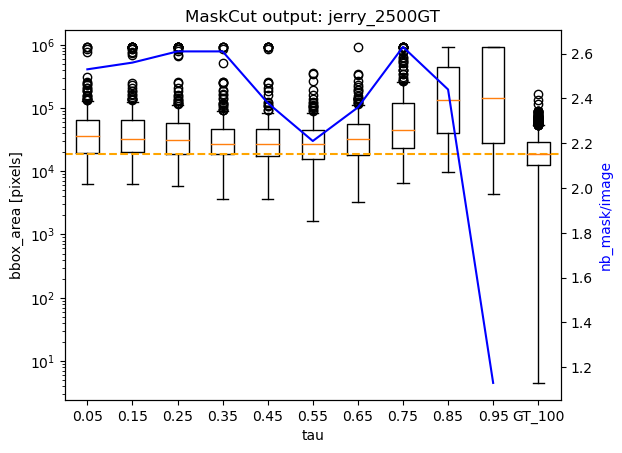

In [10]:
test_tau = join(anns,'test_tau')

nb_ann = []
areas = []
names = []


jsons = sorted([d for d in listdir(test_tau) if '.json' in d and not ('GT_j' in d or 'mc' in d)])
for j in jsons:
    with open(join(test_tau,j), 'r') as f:
        lala = json.load(f)
        
    # avg_nb_ann
    nb_ann.append(len(lala['annotations'])/len(lala['images']))
    
    #area
    areas.append([d['bbox'][2]*d['bbox'][3] for d in lala['annotations']]) #bbox
    #areas.append([d['area'] for d in lala['annotations']])                #segm (less robust)
    
    #tau
    names.append(float(j.split('.json')[0][-4:]))
    

#id = [d['id'] for d in lala['images']]
with open(json_path_GT_te, 'r') as f:
    lala = json.load(f)
    
    areas.append([d['bbox'][2]*d['bbox'][3] for d in lala['annotations']])
    #areas.append([d['area'] for d in lala['annotations'] if d['image_id'] in id])
    names.append(f'GT_{len(lala["images"])}')
    
GT_median = np.median([d['bbox'][2]*d['bbox'][3] for d in lala['annotations']])
#GT_median = np.median([d['area'] for d in lala['annotations'] if d['image_id'] in id])
    
#************************************************

# Create a figure and axes
fig, ax = plt.subplots()

# Plot each list as a boxplot
ax.boxplot(areas)

# Set x-axis tick labels
ax.set_xticklabels(names)

# Set labels and title
ax.set_xlabel('tau')
ax.set_ylabel('bbox_area [pixels]')
ax.set_title(f'MaskCut output: {dataset}')

ax.set_yscale('log')
plt.axhline(y=GT_median, color='orange', linestyle='--')

# Create a twin Axes for the second y-axis
color2 = 'blue'
ax2 = ax.twinx()

# Plot the second data using the second y-axis
ax2.plot(np.arange(1,len(nb_ann)+1), nb_ann, color=color2)

# Set labels and title for the second y-axis
ax2.set_ylabel('nb_mask/image', color=color2)
#plt.axhline(y=3, color=color2, linestyle='-.')

# Show the plot
plt.savefig(join(test_tau,'results.png'))
plt.show()

#### some GT areas are weird, check img_id 

In [17]:
with open(json_path_GT, 'r') as f:
    json_file = json.load(f)
    
threshold = 5
    
inspect=[]
ann_id=[]
for d in json_file['annotations']:
    if d['bbox'][2]*d['bbox'][3]<threshold:
        inspect.append(d['image_id'])
        ann_id.append(d['id'])

img_name=[]
for d in json_file['images']:
    if d['id'] in inspect:
        img_name.append(d['file_name'])

In [18]:
json_file['annotations'][ann_id[0]]

{'segmentation': [[1096.0,
   719.5,
   1094.5,
   719.0,
   1096.0,
   717.5,
   1096.0,
   719.5]],
 'area': 1.5,
 'iscrowd': 0,
 'image_id': 967,
 'bbox': [1094.5, 717.5, 1.5, 2.0],
 'category_id': 1,
 'id': 16474}

#### visualize the generated masks

registered: jerry_2500GT_N3_tau0.55.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_2500GT/annotations/jerry_2500GT_N3_tau0.55.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_2500GT/imgs_tau



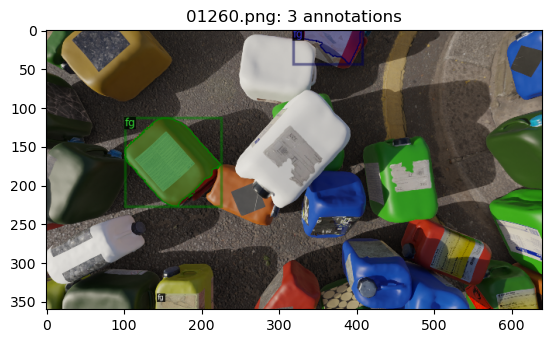

In [19]:
nb_mask = 3
tau_graph = 0.55 
tmp_json_name_mc = f'{dataset}_N{nb_mask}_tau{tau_graph}.json'

# tmp_json_path_mc = join(test_tau, tmp_json_name_mc)
tmp_json_path_mc = join(anns, tmp_json_name_mc)


registerCatalog(
    tmp_json_name_mc,
    tmp_json_path_mc,
    imgs_tau
    )

visualizeSample(0,tmp_json_name_mc)

#### **==> Run Maskcut on imgs_mc (use 11_MaskCut.ipynb)**

#### adapt json file outputed by maskcut and split it {train, test}

In [32]:
adaptMaskCutGT(json_path_mc,imgs_mc)
trainTestSplit(anns,json_name_mc,100,test_list=rdm100)

Search and replace operation completed successfully!


In [31]:
trainTestSplit(anns,json_name_GT,100,test_list=rdm100)

registered: mc_jerry_sp10.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_sp10/annotations/mc_jerry_sp10.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_sp10/imgs



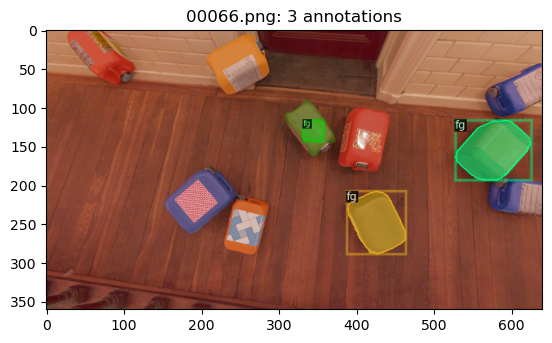

In [18]:
registerCatalog(json_name_mc,json_path_mc,imgs)
visualizeSample(66,json_name_mc)